Installing and importing all the needed packages, as well as the portfolio which will be analysed.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_rows", None, "display.max_columns", None)
portfolio = pd.read_csv('/Users/darigazaikenova/PycharmProjects/programming/my project/Berkshire.csv')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

portfolio.columns = [c.replace(' ', '_') for c in portfolio.columns]
portfolio.drop(['Name'], axis=1, inplace=True)
portfolio.rename(columns={ 'Symbol':'Ticker'},inplace=True)
                                           
tickers = portfolio['Ticker'].unique()

In [2]:
portfolio.head(10)

,Date,Type,Ticker,Shares,Price
0,2013-06-28,Buy,WFC,46313.00000,41.27000
1,2013-06-28,Buy,KO,40000.00000,40.11000
2,2013-06-28,Buy,AXP,5161.00000,74.76000
3,2013-06-28,Buy,USB,7827.00000,36.15000
4,2013-06-28,Buy,IBM,6812.00000,191.11000
5,2013-06-28,Buy,PG,5279.00000,76.99000
6,2013-06-28,Buy,WMT,4924.00000,74.49000
7,2013-06-28,Buy,GM,4000.00000,33.31000
8,2013-06-28,Buy,PSX,2716.00000,58.91000
9,2013-06-28,Buy,MCO,2492.00000,60.93000


### Current price of stock

Later to calculate the profit of the stocks which are still holded in the portfolio, current stock price will be needed. Here, in this part from the yahoofinance library, I upload the latest available stock prices. Important to note that if the day when programme is run is a saturday or sunday, then the adjusted close price of Friday will be used. Same applies for the public holidays - the latest available price is used.

In [3]:
startdate = dt.datetime.strptime(portfolio.Date.min(),"%Y-%m-%d")
startdate = startdate + dt.timedelta(days= 1)
startdate = startdate.date() 

today = dt.datetime.utcnow() + dt.timedelta(days= 1) # today's data
today_extra_holiday = dt.datetime.utcnow() + dt.timedelta(days= -4)


In [4]:
def get(ticker):
    df_list =[]
    for ticker in tickers:
        df = yf.download(ticker, start=today_extra_holiday, end=today)
        df['Ticker'] = ticker
        df_list.append(df)
    df_final = pd.concat(df_list)
    return df_final

current_price = get(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
current_price.drop_duplicates('Ticker', keep='last', inplace=True) 

In [6]:
current_price = current_price[['Adj Close', 'Ticker']]
current_price = current_price.rename(columns={'Adj Close':'Current Price'})
current_price.set_index('Ticker',inplace=True)

In [7]:
current_price.head()

,Current Price
Ticker,
WFC,43.17000
KO,54.98000
AXP,136.81000
USB,42.76000
IBM,120.04000


### Identifying which stock or its portion was bought and sold, which is still on hold

In [8]:
portfolio = portfolio.sort_values(['Ticker', 'Date'], ascending = [True, True])
portfolio['Buy/Sell Cash Flow'] = np.where(portfolio['Type'] == 'Buy', (-portfolio['Price'] * portfolio['Shares']), (portfolio['Price'] * portfolio['Shares']))
portfolio['Shares'] = np.where(portfolio['Type'] == 'Sell', -portfolio['Shares'], portfolio['Shares'])

In [9]:
portfolio['Shares Left'] = portfolio.groupby('Ticker')['Shares'].transform('sum')

In [10]:
portfolio['Fixed CF'] = portfolio.groupby('Ticker')['Buy/Sell Cash Flow'].transform('sum').round(4)

In [11]:
portfolio_1 = portfolio.drop_duplicates(subset='Ticker', keep='first')

In [12]:
portfolio_final = pd.merge(portfolio_1, current_price, how='left', on='Ticker')

In [13]:
portfolio_final = portfolio_final.drop(['Shares', 'Price', 'Type', 'Buy/Sell Cash Flow'], axis=1)

In [14]:
portfolio_final['Notfixed Cash Flow'] = portfolio_final['Current Price'] * portfolio_final['Shares Left']
portfolio_final['Notfixed Cash Flow'].fillna(0, inplace=True)
portfolio_final['Cash Flow Per Row'] = portfolio_final['Fixed CF'] + portfolio_final['Notfixed Cash Flow']

In [15]:
portfolio_final['Current Price'].fillna(0, inplace=True)

In [16]:
portfolio_final

,Date,Ticker,Shares Left,Fixed CF,Current Price,Notfixed Cash Flow,Cash Flow Per Row
0,2013-06-28,AXP,5161.00000,-385836.36000,136.81000,706076.39740,320240.03740
1,2013-06-28,BK,2464.00000,-69115.20000,38.41000,94642.23962,25527.03962
2,2013-06-28,CBI,1070.00000,-64818.30000,0.05000,53.50000,-64764.80000
3,2014-06-30,CHTR,1230.00000,-194807.40000,323.31000,397671.29700,202863.89700
4,2013-06-28,COP,437.00000,2534.25000,117.96000,51548.51960,54082.76960
5,2013-06-28,COST,433.00000,-47876.81000,454.64999,196863.44736,148986.63736
6,2013-06-28,DE,397.00000,-32256.25000,357.14001,141784.58582,109528.33582
7,2013-06-28,DISH,0.00000,831.60000,12.96000,0.00000,831.60000
8,2014-06-30,DNOW,182.00000,-6590.22000,10.51000,1912.82004,-4677.39996
9,2013-06-28,DVA,3760.00000,-314218.02000,89.39000,336106.39771,21888.37771


# Actual return on portfolio

After pre-processing the data, caclulating the actual return on portfolio

In [17]:
gained_profit_or_loss = portfolio_final['Cash Flow Per Row'].sum()

Since the portfolio is not mine and the initial budget wasn't specified, I assumed that all the stock was bought on the personal money of the investor, not on the earned money from previous investment activitites (buying and selling stocks).

In [18]:
portfolio['Sum Price'] = np.where(portfolio['Type'] == 'Buy', (portfolio['Price'] * portfolio['Shares']), 0)

In [19]:
intial_budget = portfolio['Sum Price'].sum()
intial_budget

9221878.989400001

Actual return = (ending value-beginning value)/ beginning value = actual return

In [20]:
return_on_portfolio = gained_profit_or_loss/ intial_budget
return_on_portfolio

0.2848477440511431

# Calculating the Return of indexes

As benchmarks of this portoflio, I used the most popular Indexes - S&P500 and NASDAQ. As the starting day the portfolio's first day of transaction is used and as the last day today is used. 

In [21]:
indexes = ['^GSPC', '^IXIC']

In [22]:
# get index data on the start date
def get2(indexes, startdate):
    df_list =[]
    for index in indexes:
        df = yf.download(index, start=startdate, end=startdate)
        df['Index'] = index
        df_list.append(df)
        
    df_final = pd.concat(df_list)
    return df_final

index_startdate = get2(indexes, startdate)
index_startdate = index_startdate[['Adj Close', 'Index']]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [23]:
# get index data on the end date
def get22(indexes):
    df_list =[]

    for index in indexes:
        df = yf.download(index, start=today_extra_holiday, end=today)
        df['Index'] = index
        df_list.append(df)
        
    df_final = pd.concat(df_list)
    return df_final

index_enddate = get22(indexes)
index_enddate.drop_duplicates('Index', keep='last', inplace=True) #get the data in the range, leave only the latest data
index_enddate = index_enddate[['Adj Close', 'Index']]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [24]:
market_index = pd.merge(index_startdate, index_enddate, on='Index')
market_index.rename(columns= {'Adj Close_x': 'Adj Close startdate', 'Adj Close_y': 'Adj Close enddate'}, inplace=True)
market_index['Return'] = (market_index['Adj Close enddate'] - market_index['Adj Close startdate']) / market_index['Adj Close startdate']
market_index = market_index[['Return', 'Index']]
market_index.set_index('Index', inplace=True)
market_index

,Return
Index,
^GSPC,1.23066
^IXIC,2.03280


# Portfolio Analysis (Graphs)

Visually showing the return of indexes and the portfolio. Additionally, investor could see the list of unprofitable tickers

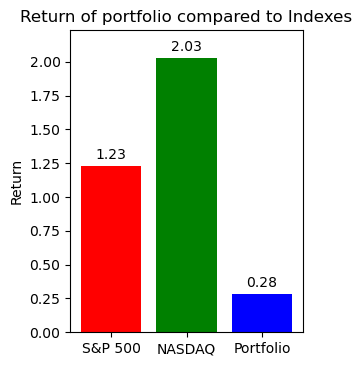

In [25]:
import matplotlib.ticker as tkr
sp500 = market_index.loc['^GSPC',"Return"]
nsdq = market_index.loc['^IXIC',"Return"]

values = [sp500, nsdq, return_on_portfolio]
def rounding(values):
    values_rounded = []
    for value in values:
        rounded = round(value, 2)
        values_rounded.append(rounded)
    return values_rounded
values_rounded = rounding(values)
colors = ['r', 'g', 'b']

# Data Visualization
fig, ax = plt.subplots(figsize=(3,4), dpi=100)
plt.bar(range(0,len(values_rounded)), values_rounded, color=colors)

plt.xticks(range(0,len(values_rounded)), ('S&P 500', 'NASDAQ', 'Portfolio'))
plt.ylabel("Return")
plt.title('Return of portfolio compared to Indexes')
plt.bar_label(ax.containers[0], label_type='edge', padding=3)
plt.margins(y=0.10)

In [26]:
def comparing_with_indexes (return_on_portfolio, sp500, nsdq):
    if return_on_portfolio > sp500 and return_on_portfolio > sp500:
        print('Congratulations, your portfolio is performing better than S&P500 and NASDAQ! Keep up!')
    elif return_on_portfolio > sp500 and return_on_portfolio < sp500:
        print('Your portfolio is performing better than S&P500, but worse than NASDAQ!')
    elif return_on_portfolio < sp500 and return_on_portfolio > sp500:
        print('Your portfolio is performing worse than S&P500, but better than NASDAQ!')
    else:
        print('Unfortunatelly, your portfolio is performing worse than S&P500 and NASDAQ. It\'s  better if you change the strategy')

comparing_with_indexes (return_on_portfolio, sp500, nsdq)

Unfortunatelly, your portfolio is performing worse than S&P500 and NASDAQ. It's  better if you change the strategy


In [27]:
portfolio_final.set_index('Ticker',inplace=True)

list_of_losing_trades = portfolio_final[(portfolio_final['Cash Flow Per Row'] < 0)].index.tolist()
print('Here is the list of tickers which were unprofitable: {}'.format(list_of_losing_trades))

Here is the list of tickers which were unprofitable: ['CBI', 'DNOW', 'GM', 'IBM', 'KRFT', 'LBTYA', 'LBTYK', 'LMCA', 'NOV', 'SNY', 'STRZA', 'V', 'VZ']
